In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=bc4c580ce30552b607f598bb52c474142683424c6b6d062f8662ba909b292624
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


**Initializing PySpark Session and Load Dataset**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean

# Initialize Spark Session
spark = SparkSession.builder.appName("BostonHousing").getOrCreate()

# Load the dataset from csv file
df = spark.read.csv("/content/BostonHousing.csv", sep=",", header = True, inferSchema=True)

In [4]:
# First 5 elements of the dataset
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [5]:
# Number of observations in the dataset
observation_count = df.count()
print(f"Number of observations: {observation_count}")

Number of observations: 506


In [6]:
# Schema of the dataset
df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



**Combining Features Using VectorAssembler**

In [7]:
from pyspark.ml.feature import VectorAssembler

# Combine all feature columns into a single vector column
feature_columns = df.columns[:-1]  # Exclude the target column 'medv'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

In [8]:
# Show the new dataframe with the features column
df.select("features").show(5, truncate=False)

+-------------------------------------------------------------------------+
|features                                                                 |
+-------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98]  |
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14] |
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03]|
|[0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94]|
|[0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33] |
+-------------------------------------------------------------------------+
only showing top 5 rows



**Standardizing Features**

In [9]:
from pyspark.ml.feature import StandardScaler

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Show the standardized features
df.select("scaledFeatures").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                                                                                                                                                      |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.4193669292132157,0.28454826934046545,-1.2866362317171998,-0.2723290676792085,-0.14407485473245793,0.4132629204530851,-0.11989476721580969,0.1400749839795616,-0.9818711878618682,-0.6659491794887344,-1.457557

**Principal Component Analysis**

In [10]:
from pyspark.ml.feature import PCA

# Perform PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df)
df_pca = pca_model.transform(df)

# Show the principal components
df_pca.select("pcaFeatures").show(5, truncate=False)


+-------------------------------------------+
|pcaFeatures                                |
+-------------------------------------------+
|[2.096223030238583,0.7723484263420728]     |
|[1.4558109894474212,0.5913999518264818]    |
|[2.0725465519481854,0.5990465781004481]    |
|[2.6089217588643487,-0.0068638262975736246]|
|[2.4557547719310775,0.09761534604617053]   |
+-------------------------------------------+
only showing top 5 rows



**Ploting PCA Components**

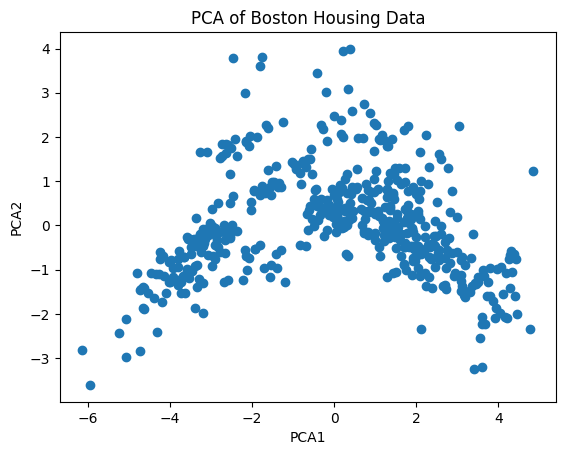

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect distributed data in numpy array
pca_features = df_pca.select("pcaFeatures").rdd.map(lambda row: row.pcaFeatures).collect()
# Convert to Pandas DataFrame
pca_df = pd.DataFrame(pca_features, columns=["PCA1", "PCA2"])

# Plot the two principal components
plt.scatter(pca_df["PCA1"], pca_df["PCA2"])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA of Boston Housing Data")
plt.show()

**Vectorizing Features and Target Variable**

In [13]:
# Vectorize features and target for Linear Regression model
df = df.withColumn("label", col("medv"))

# Select only necessary columns
df = df.select("scaledFeatures", "label")

# Show the prepared dataframe
df.show(5)

+--------------------+-----+
|      scaledFeatures|label|
+--------------------+-----+
|[-0.4193669292132...| 24.0|
|[-0.4169266699640...| 21.6|
|[-0.4169289951277...| 34.7|
|[-0.4163384035610...| 33.4|
|[-0.4120740534296...| 36.2|
+--------------------+-----+
only showing top 5 rows



**Training and Testing Split**

In [14]:
# Split the dataset into training and testing sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)

**Linear Regression**

In [15]:
from pyspark.ml.regression import LinearRegression

# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="label")
lr_model = lr.fit(train_data)

# Print model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [-0.928198063669572,1.1600495994552131,0.09469490853524046,0.7619320688343805,-2.0308782736153077,2.2530325547030974,0.1867893890339288,-3.0322376402170086,3.0887306086981754,-2.0089937911894773,-2.0950612771580586,0.9612364036817085,-4.300085324665277]
Intercept: 22.599935876244167


In [16]:
# Make predictions on the test data
test_results = lr_model.transform(test_data)

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
rmse = evaluator.evaluate(test_results)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Additional evaluation: R-squared value
r2 = evaluator.evaluate(test_results, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")

Root Mean Squared Error (RMSE): 4.571625327805613
R-squared: 0.7519253328415118


**Further Analysis of Model Performance**

In [19]:
# Show predictions
test_results.select("prediction", "label", "scaledFeatures").show(5)

# Analyze residuals
residuals = test_results.withColumn("residuals", col("label") - col("prediction"))
residuals.select("residuals").show(5)

+------------------+-----+--------------------+
|        prediction|label|      scaledFeatures|
+------------------+-----+--------------------+
| 27.34694258653266| 22.0|[-0.4188274912467...|
| 40.57014354938094| 50.0|[-0.4184961554268...|
|27.823154486711626| 24.5|[-0.4183566456079...|
| 25.94477759145833| 30.1|[-0.4181148285884...|
| 30.66369416238175| 32.9|[-0.4180346104426...|
+------------------+-----+--------------------+
only showing top 5 rows

+-------------------+
|          residuals|
+-------------------+
| -5.346942586532659|
|  9.429856450619063|
|-3.3231544867116263|
|  4.155222408541672|
|   2.23630583761825|
+-------------------+
only showing top 5 rows



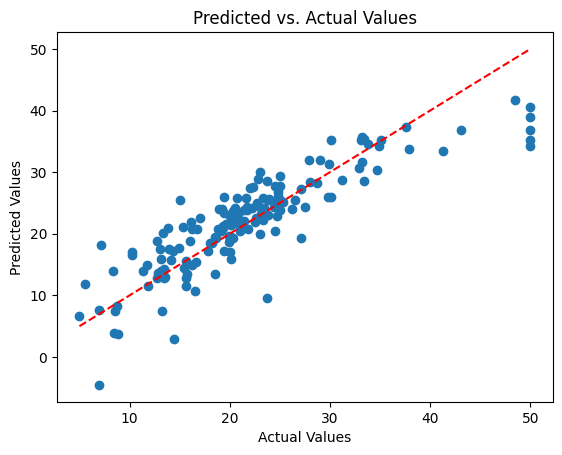

In [20]:
# Convert predictions and actual values to pandas dataframe for plotting
predictions_actuals = test_results.select("prediction", "label").toPandas()

# Scatter plot of predicted vs. actual values
plt.scatter(predictions_actuals["label"], predictions_actuals["prediction"])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.plot([predictions_actuals["label"].min(), predictions_actuals["label"].max()],
         [predictions_actuals["label"].min(), predictions_actuals["label"].max()], 'r--')
plt.show()